In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)

pd.options.mode.chained_assignment = None
cmap = plt.get_cmap("tab10")

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Check discrepancies between bria's normals and ours

In [ ]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation', 'test'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

normal_imgs_ids = db.get_normal_imgs_ids()

105 68
68


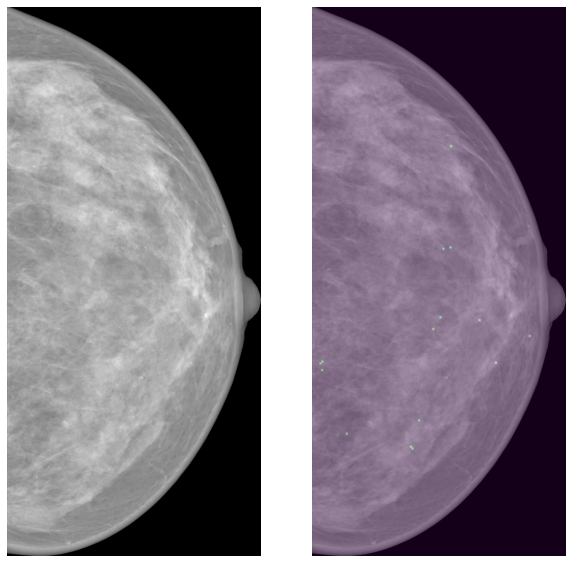

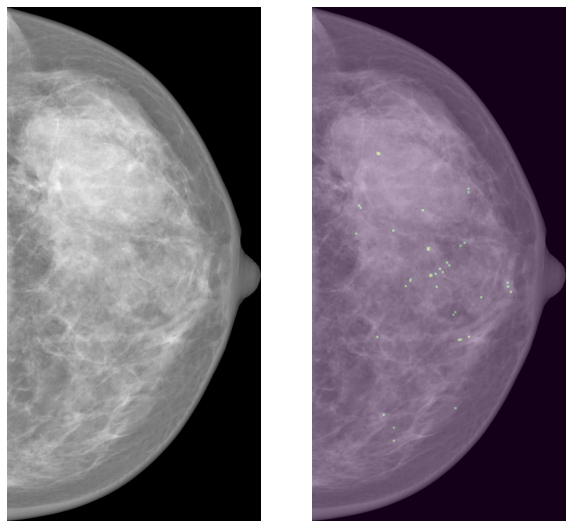

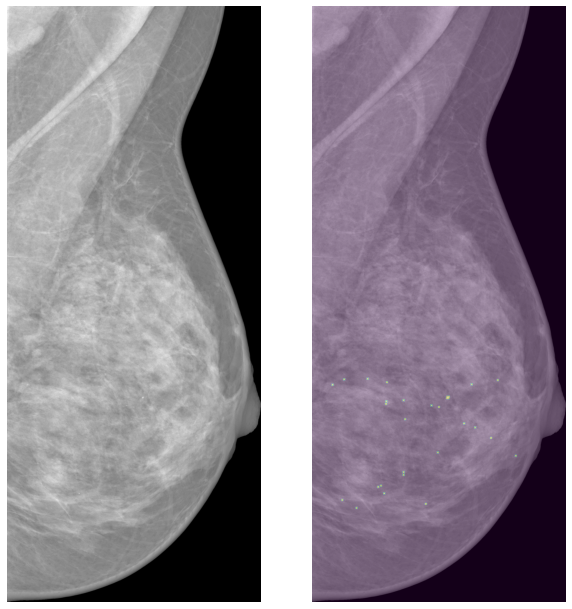

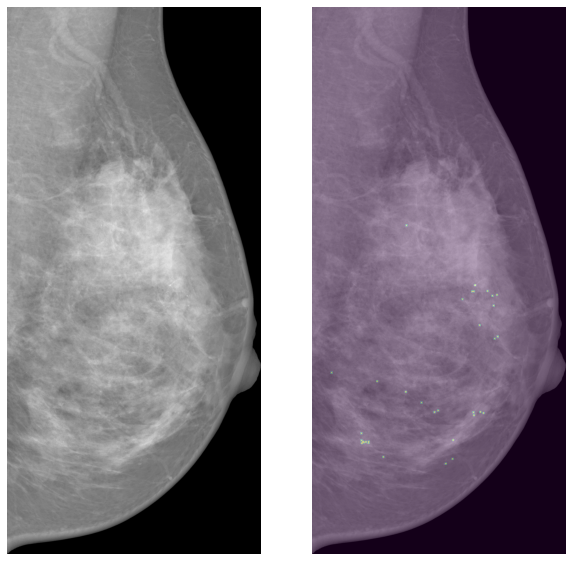

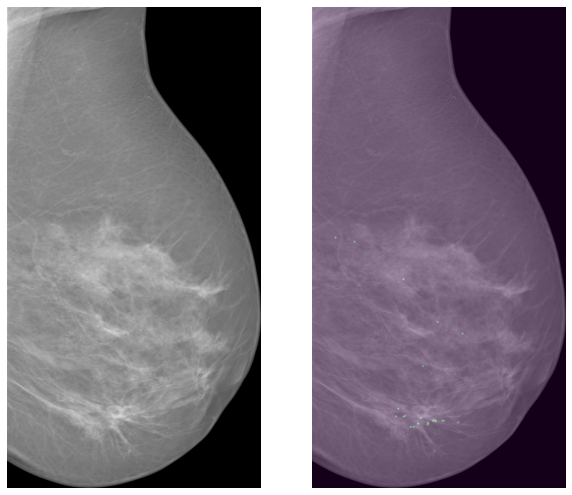

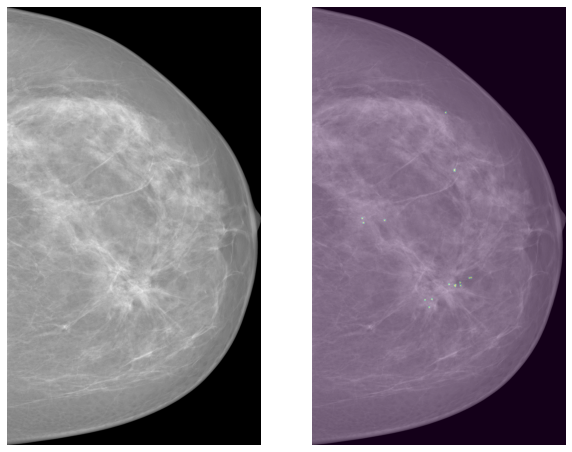

In [4]:
brias_normals = pd.read_csv(Path.cwd().parent/'data/normals.txt', index_col=False, header=None)[0].tolist()

missing = [i for i in brias_normals if i not in normal_imgs_ids]

print(len(brias_normals), len(normal_imgs_ids))
print(sum(db.df.img_label=='normal'))

imgs_to_check = db.df.loc[db.df.img_id.isin(missing) & db.df.micros].index.tolist()
for idx in imgs_to_check:
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()

In [5]:
db.df.loc[db.df.img_id.isin(missing), 'mass':'asymmetry']

,mass,micros,distortion,asymmetry
22,True,False,False,False
24,True,False,False,False
34,True,False,False,False
35,True,False,False,False
36,True,False,False,False
37,True,False,False,False
43,True,False,False,False
60,True,False,False,False
62,True,False,False,False
65,True,False,False,False


we can see that the discrepancies are cases that indeed have other kind of lesions but have also mcs, so they WON'T be considered normals.